##### CSE 847 Project (SS23)

<h2 style="text-align:center;">Marketing Lead Scoring for Sales Resource Prioritization and Revenue Forecasting!</h2>

<h3 style="text-align:center;">Eva Li, Wenting Liu</h3>

## (1) Introduction


### 1.1 Backgroud and Motivation:

- A **business-to-business Software-as-a-service (B2B SaaS)** is a model that **generates revenue through selling usage licenses to other businesses.** A natural way to **acquire more subscribers** is to establish a strong marketing presence through marketing campaigns to **attract potential prospects** to visit the websites and learn about the product. 


- **Visitors become a sales lead when they submit their information**, such as company’s size and location, through completing the online registration workflow. **Then a sales representative will reach out** and conduct the sales pitch to complete the selling process. 


- **A ranking system of sales leads** is becoming more relevant and vital as a Saas company enters into the growth stage. While both the products and marketing campaigns are scalable, the sales team is not. In practice, there is often a **mismatch in the timeline between the selas volume and the size of the sales team due to various factors**. In addition, **not all leads are equal**. For example, leads generated through referrals are easier to convert than those from a radio campaign. To address this issue, we propose a ranking system solution. 



### 1.2 Data Description:

- **Dimension:** 17,717 (rows) $\times$ 9 (columns)



- **Target:** *is_converted* 

    - The **boolean** response variable. This variable indicates whether the lead was converted, which means they subscribed to the service, within 30 days upon their lead registration.



- **Features:**

    - 6 <span style="color:blue">categorical</span>.
    
    - 2 <span style="color:green">numerical</span>.

| **Category** | **Feature** |
| :--- | :--- |
| Marketing Related attributes | <ul><li> <span style="color:blue">*Industry*</span> </ul> <ul><li> <span style="color:blue">*How did they hear us*</span> </ul> <ul><li> <span style="color:blue">*Marketing Channel*</span> </ul> <ul><li> <span style="color:blue">*Marketing Source*</span> </ul>|
| Web activity attributes | <ul><li> <span style="color:green">*Time spent on the website in that section*</span> </ul> <ul><li> <span style="color:blue">*Device used for registration*</span> </ul> <ul><li> <span style="color:green">*Time spent filling the registration form*</span> </ul> <ul><li> <span style="color:blue">*If it has scheduled a overview call*</span> </ul> |

## (2) Problem description

- **The goal** of this project is to develop a model that **predicts the probability of conversion within 30 days for each marketing lead** base on their interaction with the website and the information from the lead form. There are two desired outcomes:

    1. **The probabilistic score** of each lead could be used to bucket the leads into A, B, C, and D buckets for prioritization purposes.
    
    2. **The predicted outcome** can be used for forecasting revenue in the next 30 days to measure the success of a marketing campaign. 


- **Potential Challenges:**

    1.	**Highly imbalanced data**: A success case is when the lead was converted to a business. The training dataset is expected to have roughly $15\% - 20\%$ success cases. Therefore, the response variable is highly imbalanced. 
    
    2.	**Missing data**: Not all web activities and marketing information are available for all visitors. 

## (3) Methodology

### 3.1 Exploratory Data Analysis (EDA)

#### 3.1.1 Data Glimpse:

In [185]:
# Import libraries:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from datetime import datetime 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [186]:
# Load dataset:
df = pd.read_csv('leadscoring_v2.csv')
df.columns = [x.lower() for x in df.columns]
df_sub = df.drop(['company_id', 'company_created_date', 'first_num_of_employees'], axis=1)
print('Data dimension: ', df_sub.shape)

Data dimension:  (17717, 9)


Target (y) : 
 False    15169
True      2548
Name: is_converted, dtype: int64


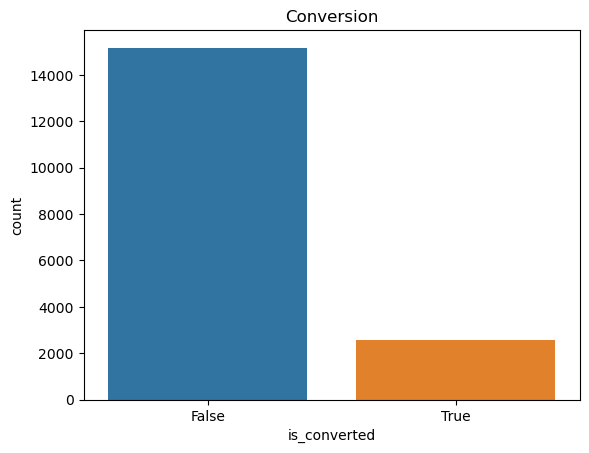

In [187]:
# The target (y):
print('Target (y) : \n', df_sub['is_converted'].value_counts())

plot_converted = sns.countplot(x='is_converted', data=df_sub)\
                    .set(title='Conversion')

In [188]:
# Features (X):
print('Features (Xs) : \n', df_sub.drop(['is_converted'], axis=1).dtypes)

Features (Xs) : 
 industry_category              object
how_did_you_hear_about_us      object
marketing_channel              object
marketing_source               object
total_web_duration              int64
reg_device_category            object
reg_session_duration          float64
is_overview_call_scheduled       bool
dtype: object


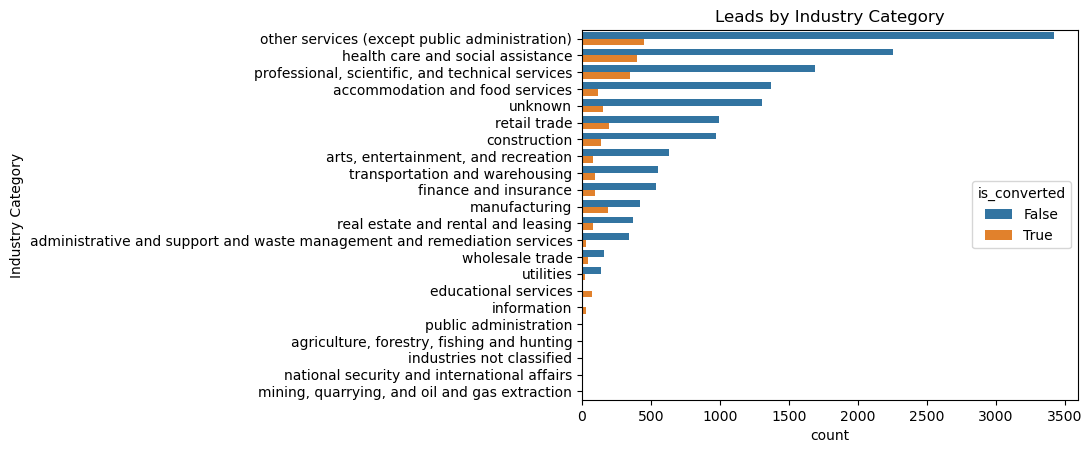

In [189]:
# "industry_category":
c = sns.countplot(y='industry_category',
                  hue='is_converted',
                  data=df_sub,
                  order=df_sub['industry_category'].value_counts().index)
c.set_title('Leads by Industry Category')
y_label = c.set_ylabel('Industry Category')

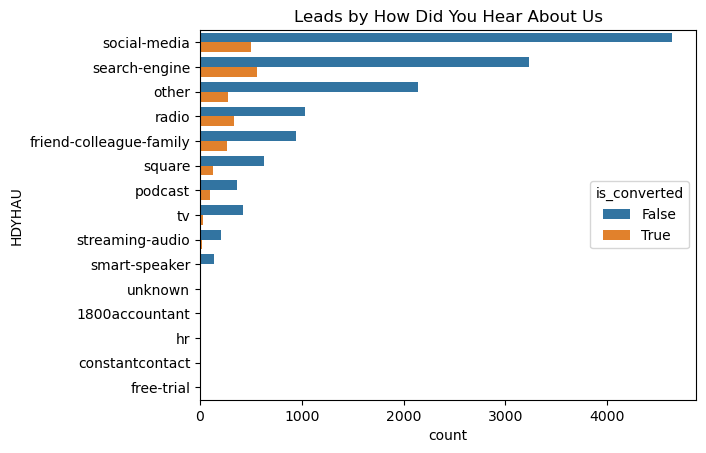

In [190]:
# "how_did_you_hear_about_us":
c = sns.countplot(y='how_did_you_hear_about_us',
                  hue='is_converted',
                  data=df_sub,
                  order=df_sub['how_did_you_hear_about_us'].value_counts().index)
c.set_title('Leads by How Did You Hear About Us')
y_label = c.set_ylabel('HDYHAU')

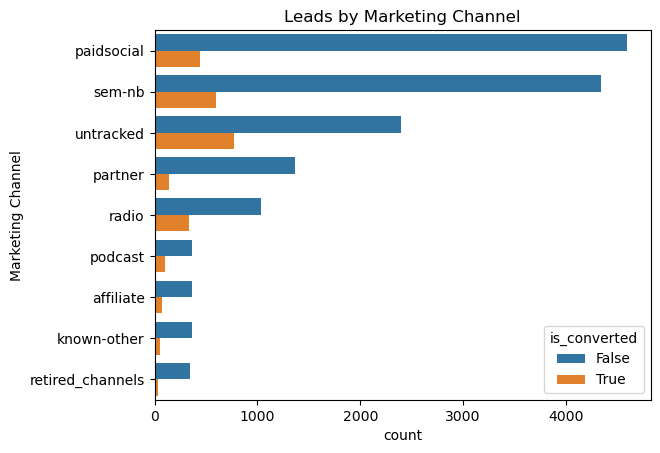

In [191]:
# "marketing_channel":
c = sns.countplot(y='marketing_channel',
                  hue='is_converted',
                  data=df_sub,
                  order=df_sub['marketing_channel'].value_counts().index)
c.set_title('Leads by Marketing Channel')
y_label = c.set_ylabel('Marketing Channel')

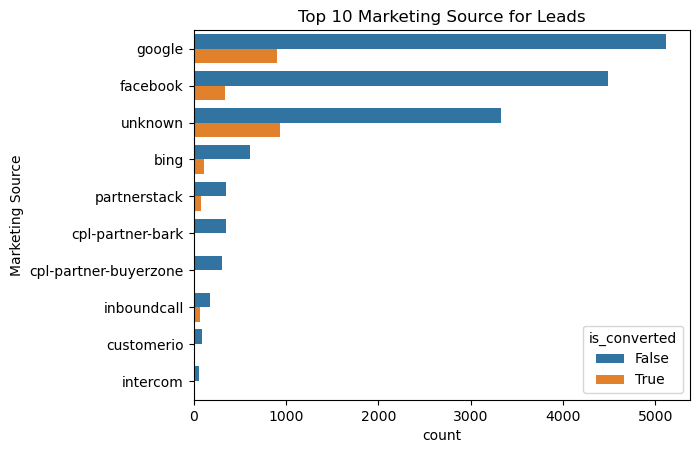

In [192]:
# "marketing_source":
c = sns.countplot(y='marketing_source',
                  hue='is_converted',
                  data=df_sub,
                  order=df_sub['marketing_source'].value_counts().iloc[:10].index)
c.set_title('Top 10 Marketing Source for Leads')
y_label = c.set_ylabel('Marketing Source')

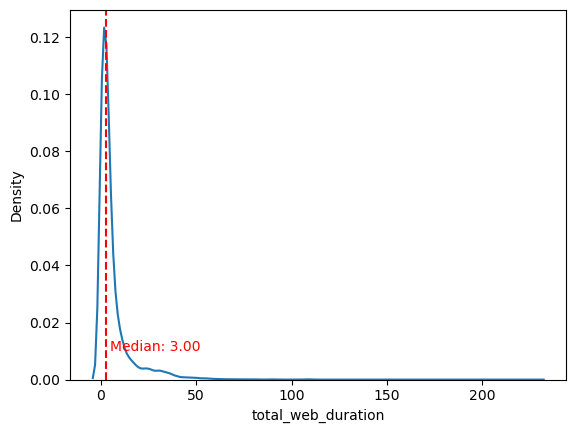

In [193]:
# "total_web_duration":
sns.kdeplot(df_sub['total_web_duration'])

# add vertical lines for meann
median = df_sub['total_web_duration'].median()
plt.axvline(median, color='red', linestyle='--')

# add text labels for mean
plt.annotate('Median: {:.2f}'.format(median), xy=(median, 0.005), xytext=(median+2, 0.01), color='red')

plt.show()

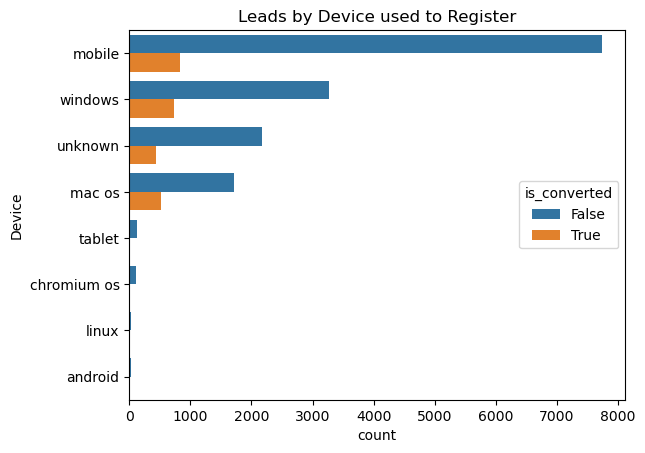

In [194]:
# "reg_device_category":
c = sns.countplot(y='reg_device_category',
                  hue='is_converted',
                  data=df_sub,
                  order=df_sub['reg_device_category'].value_counts().index)
c.set_title('Leads by Device used to Register')
y_label = c.set_ylabel('Device')

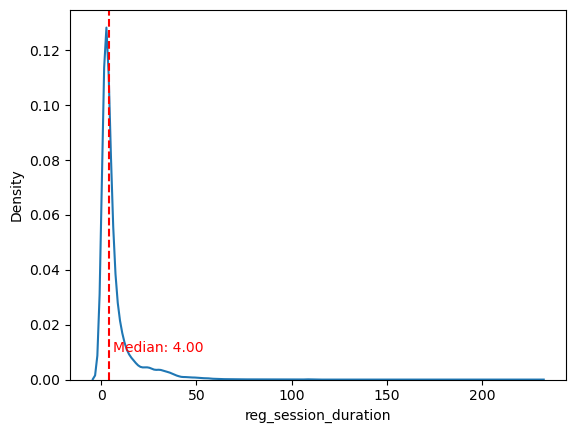

In [195]:
# "reg_session_duration":
sns.kdeplot(df_sub['reg_session_duration'])

# add vertical lines for mean
median = df_sub['reg_session_duration'].median()
plt.axvline(median, color='red', linestyle='--')

# add text labels for mean
plt.annotate('Median: {:.2f}'.format(median), xy=(median, 0.005), xytext=(median+2, 0.01), color='red')

plt.show()

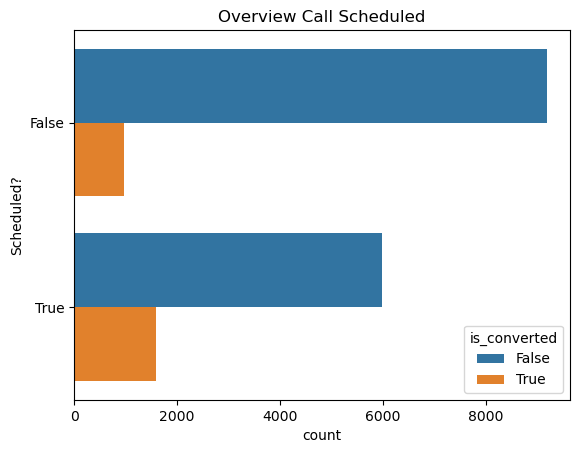

In [196]:
# "is_overview_call_scheduled":
c = sns.countplot(y='is_overview_call_scheduled',
                  hue='is_converted',
                  data=df_sub,
                  order=df_sub['is_overview_call_scheduled'].value_counts().index)
c.set_title('Overview Call Scheduled')
y_label = c.set_ylabel('Scheduled?')

In [197]:
# Missing values summary:

print('Total missing values: ', df_sub.isnull().sum().sum())
print()
print('Missing values in each feature: \n', df_sub.isnull().sum())

Total missing values:  4119

Missing values in each feature: 
 is_converted                     0
industry_category                0
how_did_you_hear_about_us     1730
marketing_channel                0
marketing_source                 0
total_web_duration               0
reg_device_category              0
reg_session_duration          2389
is_overview_call_scheduled       0
dtype: int64


#### 3.1.2 Data Pre-processing:

##### a. Missing values imputations:

   - For 1,730 missing values in *how_did_you_hear_about_us*, because it is a catogorical variable we can set missing values as one of the catogory, like **unknown**.

   - for 2,389 missing values in *reg_session_duration*, because it is a numerical variable we can use **median** to impute. 

In [198]:
# Missing value imputations:

## how_did_you_hear_about_us:
df_sub['how_did_you_hear_about_us'] = df_sub['how_did_you_hear_about_us'].fillna('unknown')

## reg_session_duration:
RSD_median = df_sub['reg_session_duration'].median()
df_sub['reg_session_duration'] = df_sub['reg_session_duration'].fillna(RSD_median)

# Check the imputation result:
df_sub.isnull().sum()

is_converted                  0
industry_category             0
how_did_you_hear_about_us     0
marketing_channel             0
marketing_source              0
total_web_duration            0
reg_device_category           0
reg_session_duration          0
is_overview_call_scheduled    0
dtype: int64

##### b. Features standardization and encoding:

In [199]:
# Standardize the numerical features:
num_cols = ['total_web_duration', 'reg_session_duration']

# create a StandardScaler object
scaler = StandardScaler()

# fit the scaler to the data and transform it
df_sub[num_cols] = scaler.fit_transform(df_sub[num_cols])

df_sub[num_cols].head()

,total_web_duration,reg_session_duration
0,-0.643492,-0.287760
1,0.387298,0.349083
2,-0.437334,-0.500041
3,-0.643492,-0.287760
4,-0.437334,-0.500041


In [203]:
# Encoding the categorical features:
cat_cols = ['industry_category', 'how_did_you_hear_about_us', 'marketing_channel'
            , 'marketing_source', 'reg_device_category', 'is_overview_call_scheduled']

X = pd.get_dummies(data=df_sub[cat_cols + num_cols], columns=cat_cols)

X.head()

,total_web_duration,reg_session_duration,industry_category_accommodation and food services,industry_category_administrative and support and waste management and remediation services,"industry_category_agriculture, forestry, fishing and hunting","industry_category_arts, entertainment, and recreation",industry_category_construction,industry_category_educational services,industry_category_finance and insurance,industry_category_health care and social assistance,...,reg_device_category_android,reg_device_category_chromium os,reg_device_category_linux,reg_device_category_mac os,reg_device_category_mobile,reg_device_category_tablet,reg_device_category_unknown,reg_device_category_windows,is_overview_call_scheduled_False,is_overview_call_scheduled_True
0,-0.643492,-0.287760,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0.387298,0.349083,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,-0.437334,-0.500041,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,-0.643492,-0.287760,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,-0.437334,-0.500041,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [214]:
# Target (y):
response_col = ['is_converted']

y = df_sub[response_col].astype(int)

y.head()

,is_converted
0,0
1,0
2,1
3,1
4,1


### 3.2 Confirmatory Data Analysis (CDA)

#### 3.2.1 Training-testing Split:

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

print("X train: ", X_train.shape)
print()
print("y train: ", y_train.value_counts())
print()
print("X test: ", X_test.shape)
print()
print("y test: ", y_test.value_counts())

X train:  (14173, 105)

y train:  is_converted
0               12101
1                2072
dtype: int64

X test:  (3544, 105)

y test:  is_converted
0               3068
1                476
dtype: int64


#### 3.2.2 Classification models:

- We applied 7 different classification models:

    - Naive Bayes (Baseline Model)
    
    - Logistic Regression (Lasso, Ridge, Weighted)
    
    - KNN
    
    - Random Forest
    
    - Xgboost
    
    - SVM (Linear, Polynomial, Radial, Sigmoid)
    
    - NN

- Use Accuracy, F1 score, Recall score, ROC Curve, AUC to do model performance comparisons.

Cross-validation scores: [0.2064129  0.204025   0.20663929 0.19303487 0.21238362]
Average cross-validation score: 0.20449913345055754
Accuracy: 0.19413092550790068
F1 score: 0.2452431289640592
Recall score: 0.9747899159663865
AUC score: 0.533602831615045


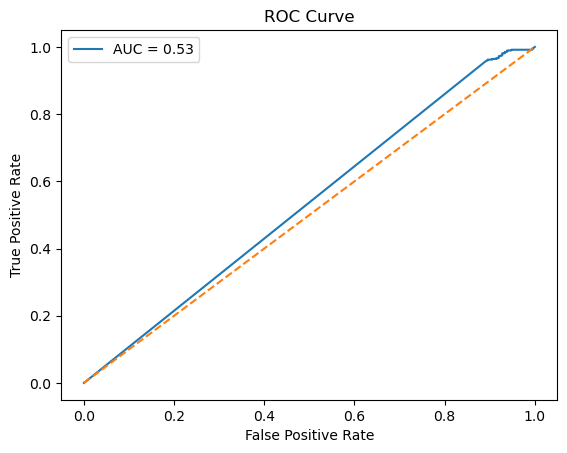

In [250]:
# Naive Bayes (Baseline Model)
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Train and evaluate model
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# Apply 5-fold cross-validation on the training data
cv_scores = cross_val_score(nb, X_train, y_train, cv=5, scoring='f1_macro')

print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, nb.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Recall score: {recall}")
print(f"AUC score: {roc_auc}")

# Plot ROC curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Cross-validation scores: [0.5461932  0.5675578  0.56790665 0.56884946 0.56313958]
Average cross-validation score: 0.562729341281924
Accuracy with Lasso regularization: 0.8696388261851016
F1 score with Lasso regularization: 0.1348314606741573
Recall score with Lasso regularization: 0.07563025210084033
AUC score with Lasso regularization: 0.7481566290140567
Accuracy with Ridge regularization: 0.8690744920993227
F1 score with Ridge regularization: 0.1310861423220974
Recall score with Ridge regularization: 0.07352941176470588
AUC score with Ridge regularization: 0.7530899745817493


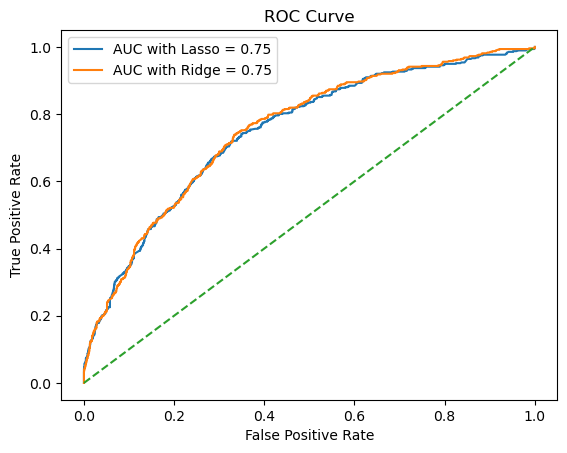

In [252]:
# Logistic Regression - Lasso and Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Train and evaluate model
lr = LogisticRegression(solver='liblinear', max_iter=1000)

# Apply 5-fold cross-validation on the training data for Logistic Regression
cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='f1_macro')

print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())

# Fit model with Lasso regularization and evaluate
lr_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=0.1)
lr_lasso.fit(X_train, y_train)
y_pred_lasso = lr_lasso.predict(X_test)

accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
f1_lasso = f1_score(y_test, y_pred_lasso)
recall_lasso = recall_score(y_test, y_pred_lasso) 
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, lr_lasso.predict_proba(X_test)[:,1])
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)

print(f"Accuracy with Lasso regularization: {accuracy_lasso}")
print(f"F1 score with Lasso regularization: {f1_lasso}")
print(f"Recall score with Lasso regularization: {recall_lasso}")
print(f"AUC score with Lasso regularization: {roc_auc_lasso}")

# Fit model with Ridge regularization and evaluate
lr_ridge = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000, C=0.1)
lr_ridge.fit(X_train, y_train)
y_pred_ridge = lr_ridge.predict(X_test)

accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
f1_ridge = f1_score(y_test, y_pred_ridge)
recall_ridge = recall_score(y_test, y_pred_ridge) 
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, lr_ridge.predict_proba(X_test)[:,1])
roc_auc_ridge = auc(fpr_ridge, tpr_ridge)

print(f"Accuracy with Ridge regularization: {accuracy_ridge}")
print(f"F1 score with Ridge regularization: {f1_ridge}")
print(f"Recall score with Ridge regularization: {recall_ridge}")
print(f"AUC score with Ridge regularization: {roc_auc_ridge}")

# Plot ROC curve
plt.plot(fpr_lasso, tpr_lasso, label=f"AUC with Lasso = {roc_auc_lasso:.2f}")
plt.plot(fpr_ridge, tpr_ridge, label=f"AUC with Ridge = {roc_auc_ridge:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [258]:
# Logistic Regression - Weighted

# Define weights
w = {0:0.15, 1:0.85}

# define model
lg2 = LogisticRegression(random_state=13,
                         class_weight=w,
                         solver='liblinear')

# fit it
lg2.fit(X_train, y_train.values.ravel())

# test
y_pred = lg2.predict(X_test)

# performance
print(f'Accuracy: {accuracy_score(y_test,y_pred)}')
print(f'F1 score: {f1_score(y_test,y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')
print(f'AUC score: {roc_auc_score(y_test, y_pred)}')

Accuracy: 0.7048532731376975
F1 score: 0.3810650887573965
Recall score: 0.6764705882352942
AUC score: 0.6928637165426796


Cross-validation scores: [0.57033839 0.58390565 0.57378013 0.58356196 0.564969  ]
Average cross-validation score: 0.5753110241051118
Accuracy: 0.8597629796839729
F1 score: 0.22464898595943839
Recall score: 0.15126050420168066
AUC score: 0.6547681817185804


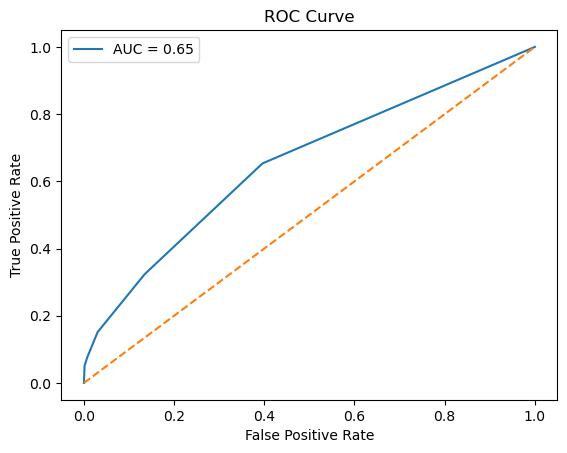

In [253]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Train and evaluate model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Apply 5-fold cross-validation on the training data
cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1_macro')

print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred) 
fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Recall score: {recall}")
print(f"AUC score: {roc_auc}")

# Plot ROC curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Cross-validation scores: [0.59966708 0.60306389 0.5987638  0.62121834 0.62893248]
Average cross-validation score: 0.610329117996108
Accuracy: 0.8552483069977427
F1 score: 0.29436038514442914
Recall score: 0.22478991596638656
AUC score: 0.714241547336014


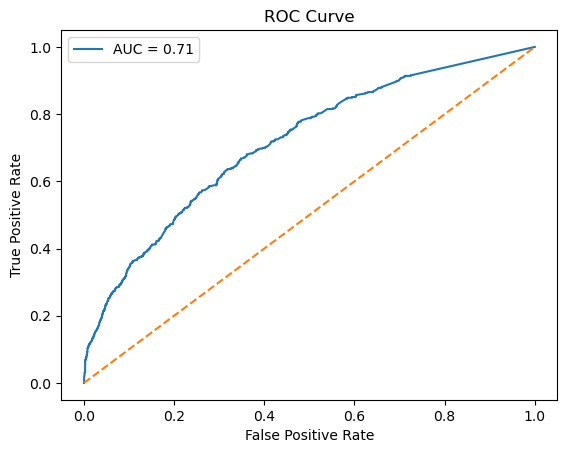

In [254]:
# Random Forest:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Train and evaluate model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# Apply 5-fold cross-validation on the training data
cv_scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='f1_macro')

print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred) 
fpr, tpr, _ = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Recall score: {recall}")
print(f"AUC score: {roc_auc}")

# Plot ROC curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Cross-validation scores: [0.59793998 0.60869038 0.60656946 0.62400593 0.62407145]
Average cross-validation score: 0.6122554423550527
Accuracy: 0.8829006772009029
F1 score: 0.3295638126009693
Recall score: 0.21428571428571427
AUC score: 0.7830896048119378


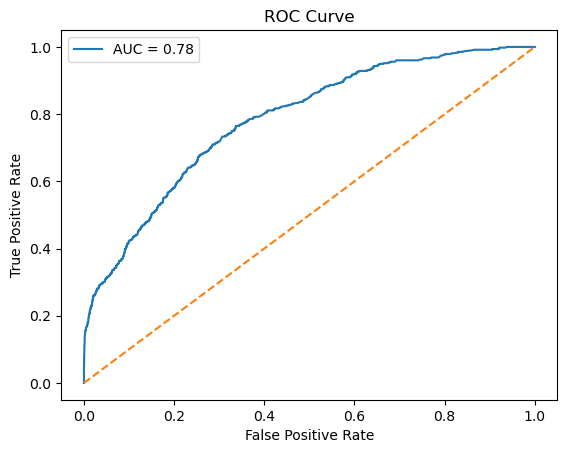

In [262]:
# Xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
import re
import warnings
warnings.filterwarnings('ignore')

# Replace special characters in feature names
X_train2 = X_train
X_train2.columns = [re.sub(r'[\[\]<]', lambda m: '_' if m.group(0) in '[]' else 'less_than', col) for col in X_train.columns]
X_test2 = X_test
X_test2.columns = [re.sub(r'[\[\]<]', lambda m: '_' if m.group(0) in '[]' else 'less_than', col) for col in X_test.columns]

# Train and evaluate model
xgb = XGBClassifier(max_depth=3)
xgb.fit(X_train2, y_train)
y_pred = xgb.predict(X_test2)

# Apply 5-fold cross-validation on the training data
cv_scores = cross_val_score(xgb, X_train2, y_train, cv=5, scoring='f1_macro')

print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred) 
fpr, tpr, _ = roc_curve(y_test, xgb.predict_proba(X_test2)[:,1])
roc_auc = auc(fpr, tpr)

print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Recall score: {recall}")
print(f"AUC score: {roc_auc}")

# Plot ROC curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Best hyperparameters: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.880079006772009
F1 score: 0.24242424242424243
Recall score: 0.14285714285714285
AUC score: 0.6754095543041205


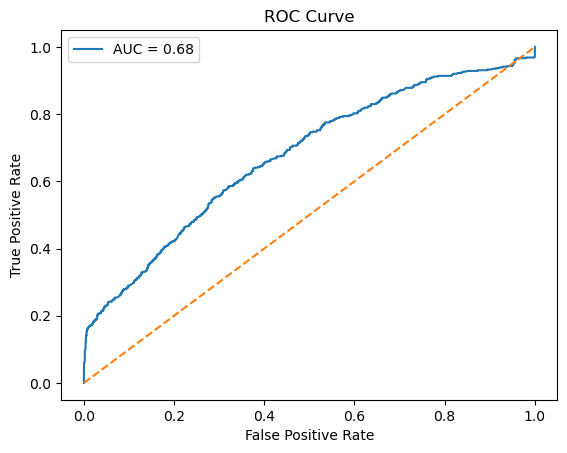

In [256]:
# SVM - Linear Kernel
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define parameter grid for grid search
param_grid = {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear']}

# Create SVM classifier with linear kernel
svm = SVC(probability=True)

# Perform grid search with 5-fold cross-validation on training data
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Train SVM with best hyperparameters on full training data
svm = SVC(C=grid_search.best_params_['C'], kernel=grid_search.best_params_['kernel'], probability=True)
svm.fit(X_train, y_train)

# Make predictions on test data
y_pred = svm.predict(X_test)

# Calculate accuracy on test data
accuracy = accuracy_score(y_test, y_pred)

# Calculate F1 score on test data
f1 = f1_score(y_test, y_pred)

# Calculate recall score on test data
recall = recall_score(y_test, y_pred) 

# Calculate ROC curve and AUC score on test data
fpr, tpr, thresholds = roc_curve(y_test, svm.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Recall score: {recall}")
print(f"AUC score: {roc_auc}")

# Plot ROC curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Best hyperparameters: {'C': 10, 'degree': 3, 'kernel': 'poly'}
Accuracy: 0.880079006772009
F1 score: 0.34108527131782945
Recall score: 0.23109243697478993
AUC score: 0.689151296111665


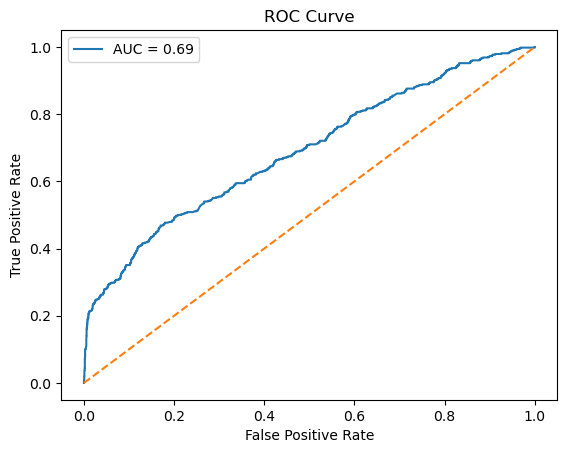

In [257]:
# SVM - Polynomial Kernel
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define parameter grid for grid search
param_grid = {'C': [0.01, 0.1, 1, 10], 'kernel': ['poly'], 'degree': [2, 3, 4]}

# Create SVM classifier with polynomial kernel
svm = SVC(probability=True)

# Perform grid search with 5-fold cross-validation on training data
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Train SVM with best hyperparameters on full training data
svm = SVC(C=grid_search.best_params_['C'], kernel=grid_search.best_params_['kernel'], degree=grid_search.best_params_['degree'], probability=True)
svm.fit(X_train, y_train)

# Make predictions on test data
y_pred = svm.predict(X_test)

# Calculate accuracy on test data
accuracy = accuracy_score(y_test, y_pred)

# Calculate F1 score on test data
f1 = f1_score(y_test, y_pred)

# Calculate recall score on test data
recall = recall_score(y_test, y_pred) 

# Calculate ROC curve and AUC score on test data
fpr, tpr, thresholds = roc_curve(y_test, svm.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Recall score: {recall}")
print(f"AUC score: {roc_auc}")

# Plot ROC curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Best hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.8831828442437923
F1 score: 0.33865814696485624
Recall score: 0.22268907563025211
AUC score: 0.6960611982733119


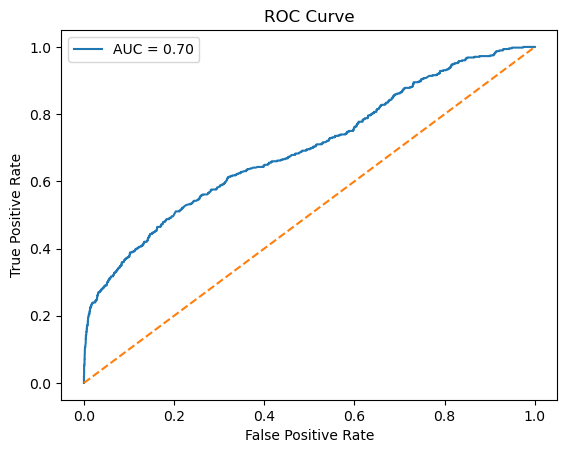

In [260]:
# SVM - Radial Kernel
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define parameter grid for grid search
param_grid = {'C': [0.01, 0.1, 1, 10], 'gamma': [0.1, 1, 10, 100], 'kernel': ['rbf']}

# Create SVM classifier with radial kernel
svm = SVC(probability=True)

# Perform grid search with 5-fold cross-validation on training data
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Train SVM with best hyperparameters on full training data
svm = SVC(C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'], kernel=grid_search.best_params_['kernel'], probability=True)
svm.fit(X_train, y_train)

# Make predictions on test data
y_pred = svm.predict(X_test)

# Calculate accuracy on test data
accuracy = accuracy_score(y_test, y_pred)

# Calculate F1 score on test data
f1 = f1_score(y_test, y_pred)

# Calculate recall score on test data
recall = recall_score(y_test, y_pred) 

# Calculate ROC curve and AUC score on test data
fpr, tpr, thresholds = roc_curve(y_test, svm.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Recall score: {recall}")
print(f"AUC score: {roc_auc}")

# Plot ROC curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Best hyperparameters: {'C': 10, 'gamma': 'auto', 'kernel': 'sigmoid'}
Accuracy: 0.8552483069977427
F1 score: 0.23546944858420268
Recall score: 0.16596638655462184
AUC score: 0.3508797097717835


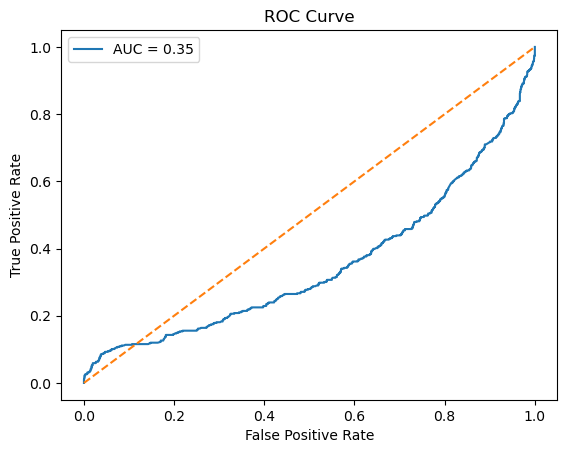

In [261]:
# SVM - Sigmoid Kernel
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define parameter grid for grid search
param_grid = {'C': [0.01, 0.1, 1, 10], 'kernel': ['sigmoid'], 'gamma': ['scale', 'auto']}

# Create SVM classifier with sigmoid kernel
svm = SVC(probability=True)

# Perform grid search with 5-fold cross-validation on training data
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Train SVM with best hyperparameters on full training data
svm = SVC(C=grid_search.best_params_['C'], kernel=grid_search.best_params_['kernel'], 
          gamma=grid_search.best_params_['gamma'], probability=True)
svm.fit(X_train, y_train)

# Make predictions on test data
y_pred = svm.predict(X_test)

# Calculate accuracy on test data
accuracy = accuracy_score(y_test, y_pred)

# Calculate F1 score on test data
f1 = f1_score(y_test, y_pred)

# Calculate recall score on test data
recall = recall_score(y_test, y_pred) 

# Calculate ROC curve and AUC score on test data
fpr, tpr, thresholds = roc_curve(y_test, svm.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Recall score: {recall}")
print(f"AUC score: {roc_auc}")

# Plot ROC curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Cross-validation scores: [0.59973931 0.61423573 0.61713446 0.62355201 0.6509704 ]
Average cross-validation score: 0.6211263812861925
Accuracy: 0.8611738148984198
F1 score: 0.3692307692307692
Recall score: 0.3025210084033613
AUC score: 0.7469381005335642


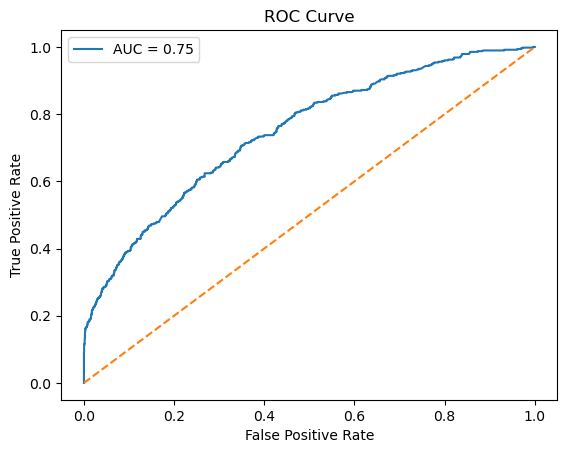

In [259]:
# Neural Network:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Train and evaluate model
nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, solver='adam', random_state=42)
nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)

# Apply 5-fold cross-validation on the training data
cv_scores = cross_val_score(nn, X_train, y_train, cv=5, scoring='f1_macro')

print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, nn.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Recall score: {recall}")
print(f"AUC score: {roc_auc}")

# Plot ROC curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### (4) Results

#### 4.1 Model Performances:

- We applied 12 different classification models:


| Model Name | Hyperparameter | Average CV Score | Accuracy Score | F1 Score | Recall Score | AUC Score |
| :-------- | :-------- | :-------- | :-------- | :-------- | :-------- | :-------- |
| Naive Bayes (Baseline) | / | 0.20 | 0.19 | 0.25 | **0.97** | 0.53 |
| Logistic Regression - Lasso | max_iter=1000, C=0.1, solver='liblinear' | 0.56 | 0.87 | 0.13 | 0.08 | 0.75 |
| Logistic Regression - Ridge | max_iter=1000, C=0.1, solver='liblinear' | 0.56 | 0.87 | 0.13 | 0.07 | 0.75 |
| Logistic Regression - Weighted | class_weight={0:0.15, 1:0.85}, solver='liblinear' | 0.56 | 0.70 | **0.38** | 0.68 | 0.69 |
| K Nearest Neighbor | k=5 | 0.58 | 0.86 | 0.22 | 0.15 | 0.65 |
| Random Forests | n_estimators=100 | 0.61 | 0.86 | 0.29 | 0.22 | 0.71 |
| Xgboost | max_depth=3 | 0.61 | **0.88** | 0.33 | 0.21 | **0.78** |
| SVM - Linear | 'C'=1 | / | **0.88** | 0.24 | 0.14 | 0.68 |
| SVM - Polynomial | 'C'=10, 'degree'=3 | / | **0.88** | 0.34 | 0.23 | 0.69 |
| SVM - Radial | 'C'=10, 'gamma'=0.1 | / | **0.88** | 0.34 | 0.22 | 0.70 |
| SVM - Sigmoid | 'C'=10, 'gamma'='auto' | / | 0.86 | 0.24 | 0.17 | 0.35 |
| Neural Network | hidden_layer_sizes=(100,), max_iter=1000, solver='adam' | 0.62 | 0.86 | 0.37 | 0.30 | 0.75 |

- Terms meaning:

    - **Average CV Score**: it can be used to assess the generalization performance of a machine learning model before it is applied to new, unseen data. 
    
    - **Accuracy Score**: it measures the proportion of correctly classified samples among all the samples in a dataset. It is calculated as the number of correct predictions divided by the total number of predictions. 

    - **F1 Score**: it is a harmonic mean of precision and recall and provides a balance between these two metrics. Precision measures the proportion of true positive predictions among all the predicted positive examples, while recall measures the proportion of true positive predictions among all the actual positive examples.

    - **Recall Score**: it is a performance metric that measures the proportion of true positive predictions among all the actual positive examples. It is also known as sensitivity or true positive rate. A high recall score indicates that the model can correctly identify most of the positive examples in the dataset, which is useful when the cost of missing positive examples is high, such as in medical diagnoses. On the other hand, a low recall score indicates that the model is missing a significant number of positive examples, and this may be a cause for concern in some applications.

    - **AUC Score**: the AUC (Area Under the ROC Curve) score is a performance metric used to evaluate the binary classification models' ability to distinguish between positive and negative classes.


*(All scores' range above are between 0 and 1, which 0.5 is equivalent to random guessing, and 1 indicates perfect performance.)*


#### 4.2 Results:

- For accuracy score, the best performance models are: *Xgboost, SVM - Linear, SVM - Polynomial, SVM - Radial*, and the score is *0.88*.


- For f1 score, the best performance model is: **Logistic Regression - Weighted**, and the score is **0.38**.


- For recall score, the best performance model is: *Naive Bayes*, and the score is *0.97*.


- For AUC score, the best performance model is: **Xgboost**, and the score is **0.78**.


- However, since we have imbalanced data, and we care more about false positive rate in this project (because we have limited size of sales team, so we would like to decrease the chance that wrongly pay the time and source to the clients that are actually not interested in.) In this case, we will only focus on f1 score and AUC score, which indicates **Logistic Regression - Weighted** and **Xgboost** will be the final models that we use.

### (5) Conclusions and future work:

#### 5.1 Conclusions:

Our project aims to explore various classification models for marketing lead scoring, with the goal of prioritizing sales resources and forecasting revenue. We invested significant effort in data pre-processing, feature engineering, model selection, and comparing model performance. After conducting a thorough review of the literature and implementing these models in practice, we discovered that using weighted values with Logistic Regression and Xgboost can improve prediction accuracy.


#### 5.2 Future work:

Moving forward, there are several ways we could improve our models, such as utilizing hyperparameter tuning, ensemble methods, and PCA. In addition, we could explore alternative methods for imputing missing values, such as sparse learning or soft-SVD, instead of relying solely on median imputation.

### Reference

1.	Wang, Chen, et al. “Imbalance-XGBoost: Leveraging Weighted and Focal Losses for Binary Label-Imbalanced Classification with XGBoost.” Pattern Recognition Letters, June 2020, https://doi.org/10.1016/j.patrec.2020.05.035. Accessed 5 June 2020.

2.	Thabtah, Fadi, et al. “Data Imbalance in Classification: Experimental Evaluation.” Information Sciences, vol. 513, Mar. 2020, pp. 429–441, https://doi.org/10.1016/j.ins.2019.11.004.

3.	Rogić, Sunčica, et al. “Customer Response Model in Direct Marketing: Solving the Problem of Unbalanced Dataset with a Balanced Support Vector Machine.” Journal of Theoretical and Applied Electronic Commerce Research, vol. 17, no. 3, 21 July 2022, pp. 1003–1018, https://doi.org/10.3390/jtaer17030051. Accessed 21 July 2022.

4.	Banerjee, Somnath, and Pradeep Bhardwaj. “Aligning Marketing and Sales in Multi-Channel Marketing: Compensation Design for Online Lead Generation and Offline Sales Conversion.” Journal of Business Research, vol. 105, Dec. 2019, pp. 293–305, https://doi.org/10.1016/j.jbusres.2019.06.016.

5. ChatGPT